# Retaining existing customers at Beta Bank
Background:
- Customers are churning at Beta Bank. Want to retain existing customers

Goal:
- Our goal is use customers past behavior and termination of contracts with the bank to predict whether customer will churn. The model will need F1 score at least 0.59

Stages:
- We have already performed the data processing step earlier, so we will focus on creating the model here.

- Since we are predicting churn or not, we will use classification models as opposed to regression models.

- We will set the F1 score to at least 0.59. We will split the data into training set, validation set and a test set.

<div class="alert alert-block alert-warning">
<b></b> <a class="tocSkip"></a>   
    
> # Contents <a id='back'></a>
> * [Introduction](#intro)
    * [Stage 1. Importing libraries](#Import-Libraries)
    * [Stage 2. Data Processing](#Data-Processing)
    * [Stage 3. Preparing data](#Preparing-data)
    * [Stage 4. Splitting data](#Splitting-data)
    * [Stage 5. Imbalanced data check](#Imbalanced-data-check)
    * [Stage 6. Baseline logistic regression check for imbalanced data](#Baseline-logistic-regression-check-for-imbalanced-data)
    * [Stage 7. Random upsampling](#Random-upsampling)
    * [Stage 8. Class weight adjustment](#Class-weight-adjustment)
    * [Stage 9. SMOTE](#SMOTE)
    * [Stage 10. Random Under Sampler](#Random-Under-Sampler)
    * [Stage 11. Testing Dataset](#Testing-Dataset)
> * [Conclusion](#Conclusion)

# Import Libraries

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
import numpy as np

# Data Processing

In [2]:
try:
    churn = pd.read_csv('/Users/dankeichow/Downloads/Churn.csv')
except:
    churn = pd.read_csv('/datasets/Churn.csv')

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
churn.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Observation

There are 13 columns with 10,000 rows data in general.

First glance of the data is that:
- Columns are in capital letters
- There are missing values in tenure column

To tackle the above:
- Will first convert all column names to lower case and study more on tenure column
- Tenure column represents the years for customer's fixed deposits. Therefore, will investigate the tenure and see what to replace the missing value

Afterwards, will see if there is duplicate

In [5]:
# Convert columns to lower case

churn.columns = churn.columns.str.lower()

churn

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [6]:
# Understanding the tenure column

churn['tenure'].value_counts(normalize=True, dropna=False)

tenure
1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
5.0     0.0927
7.0     0.0925
NaN     0.0909
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: proportion, dtype: float64

<Axes: ylabel='Frequency'>

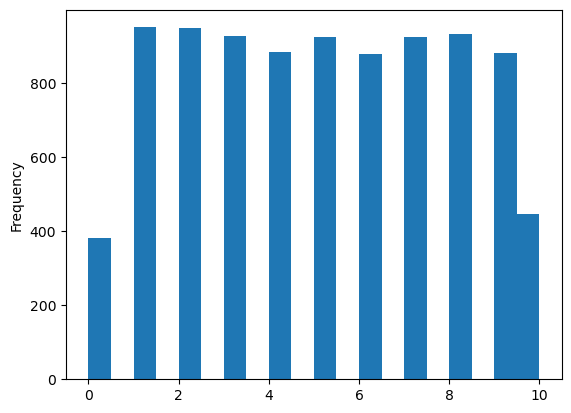

In [7]:
# Observing data distribution of tenure column

churn['tenure'].plot(kind='hist', bins=20)

## Observation

Since there are 9% of missing values of the entire tenure column, this is too larget to simply drop the rows.

Assuming rows with null data means the customers never had fixed deposit with the bank, maybe we could assign missing values as 0. However, there are 3% of rows with 0 year tenure. That leads me thinking that since tenure column is in the unit of 'Year', there could be short term deposits 3 months then it may be 0 year. Therefore, I do not think we can assign the missing values with 0.

Then I thought of assigning with -1 but I do not think it is appropriate because the tenure may potentially be a feature to train our model with. If I assign it to -1 then it may lead the model to think the customers have negative amount of time for fixed deposit and lead to wrong learning of the model.

With the chart above, the distribution of tenure column data looks quite evenly distributed.

Therefore, I think it will be best to fill the null with median so it will not introduce any bias into the model

In [8]:
churn['tenure'].median()

5.0

In [9]:
# Filling in missing value for tenure

churn['tenure'] = churn['tenure'].fillna(churn['tenure'].median())
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [10]:
#Check if there is duplicates in the data

print(churn.duplicated().sum())

0


Column names are updated to lower case, missing values are filled in tenure column and checked that there is no duplicate of data. The data is ready for further processing.

# Preparing data

The data has 13 columns and I will drop 3 columns `rownumber`, `customerid`, and `surname` as they are likely not predictive of customer churn.

In [11]:
churn = churn.drop(['rownumber','customerid','surname'], axis=1)

In [12]:
churn.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


There are 2 categorical features within the dataset. They are `gender` and `geography` and we will use one hot encoding to transform the data.


In [13]:
# Use One Hot Encoding to tranform gender column into numerical features

churn_ohe = pd.get_dummies(churn, drop_first=True)
churn_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False


I will also leverage feature scaling to prepare our data to make sure all features are considered equally important before training the model.

For example, the scale between balance and age are very different. However, I do not want the model to place higher importance on balance simply because the values is greater.

In [14]:
from sklearn.preprocessing import StandardScaler

numeric = ['creditscore',
           'age',
           'tenure',
           'balance',
           'estimatedsalary']

scaler = StandardScaler()
scaler.fit(churn_ohe[numeric])
churn_ohe[numeric] = scaler.transform(churn_ohe[numeric])

In [15]:
churn_ohe.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,-0.326221,0.293517,-1.086246,-1.225848,1,1,1,0.021886,1,False,False,False
1,-0.440036,0.198164,-1.448581,0.117350,1,0,1,0.216534,0,False,True,False
2,-1.536794,0.293517,1.087768,1.333053,3,1,0,0.240687,1,False,False,False
3,0.501521,0.007457,-1.448581,-1.225848,2,0,0,-0.108918,0,False,False,False
4,2.063884,0.388871,-1.086246,0.785728,1,1,1,-0.365276,0,False,True,False


Now creating seperate dataset for features and target

In [16]:
# Creating features and target dataset


features = churn_ohe.drop(['exited'], axis=1)
target = churn_ohe['exited']


# Splitting data

First, we will solve our imbalance data for `exited` then we will split the data.

Since test set does not exist, the source data has to be split into 3 parts: train, validation and test sets. The size of validation set and test set are usually equal.

Training data: 60%
Validating data: 20%
Test data: 20%

We will have to set a specific random state value in order to ensure the reproducibility. We want to ensure that the splits remain the same even if the code is executed multiple times.

In [17]:
# Splitting the data into train, validation and test sets

# First step, splitting the data into a training set and a test set; 80% training and 20% test

# Using stratify parameter to solve imbalance of class

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target )



In [18]:
#Second step, use the splitted 80% training data and split 20% out for validation set

features_train, features_val, target_train, target_val = train_test_split(
    features_train, target_train, test_size=0.2, random_state=12345, stratify=target_train )

features_train.shape


(6400, 11)

In [19]:
test = [features_train, target_train,features_val,target_val,features_test,target_test]

for shape in test:
    test2 = shape.shape
    print(f'shape of data {test2}')



shape of data (6400, 11)
shape of data (6400,)
shape of data (1600, 11)
shape of data (1600,)
shape of data (2000, 11)
shape of data (2000,)


In [20]:
type(features_train)

pandas.core.frame.DataFrame

In [21]:
type(target_train)

pandas.core.series.Series

The datasets we have splitted now are:

`training`: features_train, target_train

`validation`: features_val, target_val

`test`: features_test, target_test

There are 6400 rows of data in our training set; 1600 rows of data in our validation set, and 2000 rows in our testing data.

# Imbalanced data check

exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64

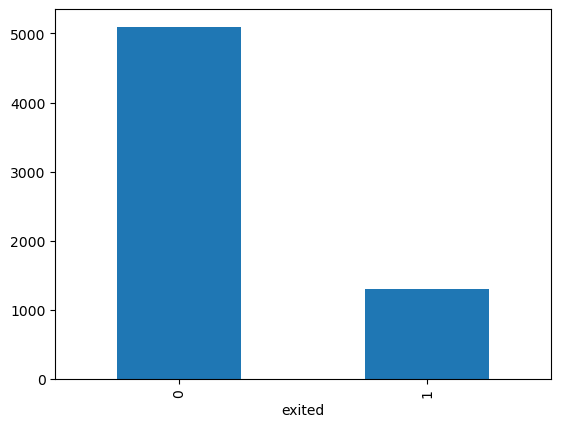

In [22]:
# Examine if there is an imbalance class of data within exit column

target_train.value_counts().plot(kind='bar')
target_train.value_counts(normalize=True)

We can see that there is an imbalance of class within our target column, `exited`, in our training data. The number of customers that have <b>not</b> exited is almost 4 times higher than customers that <b>churned</b>.

Imbalance of data will make it difficult to train a machine learning model to accurately predict churn because:

- model cannot learn to predict the minority class, churn, well
- model may only be able to learn simple heuristic; always predict the dominate class, non-churn
- minority class will become more important than the majority class because a wrong prediction on the minority class can be more costly

Therefore, we will solve the imbalance data by upsampling the minority class. The advantage of upsampling is that there will be no loss of information but may have overfitting problem.

# Imbalanced data

Our goal is to reach 0.59 F1 score with our models. F1 score is the harmonic means between recall and precision score.
The score ranges between 0 to 1 with 1 being the perfect score.

### Logistic Regression

In [23]:
from sklearn.metrics import f1_score

In [24]:
# 1st model: logistic regression
# Imported above but just fyi: from sklearn.linear_model import LogisticRegression

lr_model_imbalanced = LogisticRegression(random_state = 12345, solver='liblinear') #create an empty model
lr_model_imbalanced.fit(features_train,target_train) #train the model with training data


LogisticRegression(random_state=12345, solver='liblinear')

### Random Forest

In [25]:

# Define the hyperparameters to use and their ranges in the param_dist dictionary

param_rf = {'n_estimators': np.arange(1,10),
              'max_depth': np.arange(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 12345)

# Use grid search to find the best hyperparameters
rand_search = GridSearchCV(rf,
                            param_grid = param_rf)

# Fit grid search to the data
rand_search.fit(features_train,target_train)

# Storing best random forest hyperparameters
best_rf_imbalanced = rand_search.best_estimator_
print(f'Best random forest hyperparameters are {best_rf_imbalanced}.')


Best random forest hyperparameters are RandomForestClassifier(max_depth=9, n_estimators=9, random_state=12345).


### Decision Tree

In [26]:
# Define hyperparameter and store in dictionary
param_dt = {'max_depth': np.arange(1,20)}

# Create decision tree classifier
dt = DecisionTreeClassifier(random_state=12345)

# User random search to find the best hyperparameters

grid_search_dt = GridSearchCV(dt,
                                   param_grid = param_dt)

# Fit random search to the data
grid_search_dt.fit(features_train, target_train)

# Storing best decision tree hyperparameters
best_dt_imbalanced = grid_search_dt.best_estimator_

print(f'Best decision tree hyperparameter is {best_dt_imbalanced}.')

Best decision tree hyperparameter is DecisionTreeClassifier(max_depth=5, random_state=12345).


### Scores from above models

In general, the F1 score is a good measure of accuracy for binary classification problems where both precision and recall are important. However, the ROC AUC score is a better measure of accuracy for binary classification problems where only one of precision or recall is important.


In [27]:
# Store all models above in a variable

imbalanced_model = [lr_model_imbalanced, best_rf_imbalanced,best_dt_imbalanced]

# Create dataframe to store F1 data for all models
imbalanced_table = pd.DataFrame(columns=['Logistic Regression','Random Forest','Decision Tree'])

# Create an empty list for F1 score
f1_list = []
precision_list = []
recall_list = []
roc_auc_list = []

# F1 score for validation set
for model in imbalanced_model:
    predicted_val = model.predict(features_val)
    precision = round(precision_score(target_val,predicted_val),2)
    recall = round(recall_score(target_val,predicted_val),2)
    f1 = round(f1_score(target_val, predicted_val),2)
    probabilities_val = model.predict_proba(features_val)
    probabilities_one_val = probabilities_val[:,1]
    roc_auc = round(roc_auc_score(target_val,probabilities_one_val),2)
    precision_list.append(precision)
    recall_list.append (recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)

# Assigning data into table
imbalanced_table.loc['precision'] = precision_list
imbalanced_table.loc['recall'] = recall_list
imbalanced_table.loc['F1'] = f1_list
imbalanced_table.loc['roc_auc'] = roc_auc_list

imbalanced_table

f1_list


[0.32, 0.56, 0.53]

Precision provides the sense of the quality of positive results and recall is % of actual positives that are correctly classified.

ROC (receiver operating characteristic)makes it easy to identify the best threshold while AUC helps to decide which classification model is better.

Random forrest has higher F1 score and roc_auc score but we are unable to achieve F1 score of 0.59. Therefore, we will keep trying.


# Random upsampling

Our first method of handling imbalanced data is upsampling. We will randomly general new samples for the minority until it matches the same size as the majority class.

In [28]:
# Using imbalanced-learn library to handle imbalanced dataset. Install the library if needed

# pip install imbalanced-learn

# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn

In [29]:
# Upsample the minority class randomly

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=12345)
features_train_ros, target_train_ros = ros.fit_resample(features_train, target_train)

<Axes: xlabel='exited'>

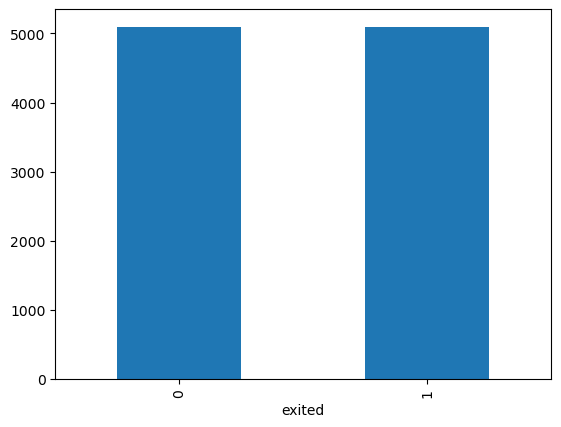

In [30]:
# Examine the numbers of targer column, exited

target_train_ros.value_counts(normalize=True)
target_train_ros.value_counts().plot(kind='bar')

We now have a balanced class of data and we will try training our model with balanced data.

### Logistic Regression

In [31]:
# Create an empty model

lr_model_upsample = LogisticRegression(random_state=12345, solver='liblinear')

# Train the model with balanced data
lr_model_upsample.fit(features_train_ros, target_train_ros)

LogisticRegression(random_state=12345, solver='liblinear')

### Random Forest

In [32]:
# Create dictionary to store hyperparameters

param_rf_upsample = {'n_estimators':np.arange(1,10),
                      'max_depth': np.arange(1,20)}

# Create a random model

rf = RandomForestClassifier(random_state=12345)

# Use grid search to find best hyperparameter

rf_grid_upsample = GridSearchCV(rf, param_grid = param_rf_upsample)

# Fit random search

rf_grid_upsample.fit(features_train_ros, target_train_ros)

# Assign best hyperparameter to a variable

best_rf_upsample = rf_grid_upsample.best_estimator_

print(f' Best hyperparameter for random forest using random upsampling is {best_rf_upsample}')

 Best hyperparameter for random forest using random upsampling is RandomForestClassifier(max_depth=18, n_estimators=8, random_state=12345)


### Decision Tree

In [33]:
# Create dictionary for hyperparametr

param_dt_upsample = {'max_depth':np.arange(1,20)}

# Create a random decision tree

dt = DecisionTreeClassifier(random_state=12345)

# Use grid search to find best hyperparameter

dt_grid_upsample = RandomizedSearchCV(dt, param_distributions = param_dt_upsample)

# Fit grid search

dt_grid_upsample.fit(features_train_ros,target_train_ros)

# Assign best hyperparameter to a variable

best_dt_upsample = dt_grid_upsample.best_estimator_

print(f' Best hyperparameter for decision tree using random upsampling is {best_dt_upsample}')


 Best hyperparameter for decision tree using random upsampling is DecisionTreeClassifier(max_depth=19, random_state=12345)


### Scores from above models with balanced data using random over sampler

In [34]:
upsample_model = [lr_model_upsample, best_rf_upsample, best_dt_upsample]

#Create an empty dataframe with columns

upsample_data = pd.DataFrame(columns=['Logistic Regression','Random Forest','Decision Tree'])

recall_upsample_list = []
precision_upsample_list = []
f1_upsample_list = []
roc_auc_upsample_list =[]

for model in upsample_model:
    predictions_val = model.predict(features_val)
    recall = round(recall_score(target_val,predictions_val),2)
    precision = round(precision_score(target_val,predictions_val),2)
    f1 = round(f1_score(target_val, predictions_val),2)
    probabilities_val = model.predict_proba(features_val)
    probabilities_one_val = probabilities_val[:,1]
    roc_auc = round(roc_auc_score(target_val,probabilities_one_val),2)
    recall_upsample_list.append(recall)
    precision_upsample_list.append(precision)
    f1_upsample_list.append(f1)
    roc_auc_upsample_list.append(roc_auc)

#Adding data to dataframe

upsample_data.loc['recall'] = recall_upsample_list
upsample_data.loc['precision'] = precision_upsample_list
upsample_data.loc['f1'] = f1_upsample_list
upsample_data.loc['roc_auc'] = roc_auc_upsample_list

upsample_data


,Logistic Regression,Random Forest,Decision Tree
recall,0.71,0.50,0.50
precision,0.40,0.63,0.46
f1,0.51,0.56,0.48
roc_auc,0.79,0.81,0.67


The F1 score remains the same for random forest but improved for logistic regression and decision tree model. We will keep trying as it has not achieved 0.59 F1 score yet.

# Class weight adjustment

Since there are more 0s (non-churn) customers than 1s (churned) customers, we would like the model to place higher weight to the 1s (churned. Therefore, we will use `class_weight` parameter in our model.

### Logistic Regression

In [35]:
# Create an empty model

lr_model_cw = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

# Train the model

lr_model_cw.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='liblinear')

### Random Forest

In [36]:
# Create dictionary for hyperparameter

param_rf_cw = {'n_estimators': np.arange(1, 10),
               'max_depth': np.arange(1, 20)}

# Create random model

rf_cw = RandomForestClassifier(random_state=12345, class_weight='balanced')

# Use grid search to find best hyperparameter
rf_grid_cw = GridSearchCV(rf_cw, param_grid=param_rf_cw)

# Fit grid search
rf_grid_cw.fit(features_train, target_train)

# Assign best grid search to a variable
best_rf_cw = rf_grid_cw.best_estimator_

print(f' Best hyperparameter for random forest using random upsampling is {best_rf_cw}')

 Best hyperparameter for random forest using random upsampling is RandomForestClassifier(class_weight='balanced', max_depth=17, n_estimators=9,
                       random_state=12345)


### Decision Tree

In [37]:
# Create dictionary for hyperparameter

param_dt_cw = {'max_depth': np.arange(1,20)}

# Create random model

dt_cw = DecisionTreeClassifier(random_state=12345, class_weight='balanced')

# Find the best hyperparameter using random search

dt_grid_cw = GridSearchCV(dt_cw, param_grid = param_dt_cw)

# Fit the training data with ramdom search

dt_grid_cw.fit(features_train, target_train)

# Assign the best hyperparameter

best_dt_cw = dt_grid_cw.best_estimator_

print(f' Best hyperparameter for decision tree using random upsampling is {best_dt_cw}')

 Best hyperparameter for decision tree using random upsampling is DecisionTreeClassifier(class_weight='balanced', max_depth=19,
                       random_state=12345)


### Scores from above models with balanced data using class weight

In [38]:
cw_balanced_models =[lr_model_cw, best_rf_cw, best_dt_cw]

def scores (list_of_models):

    data = pd.DataFrame(columns=['Logistic Regression','Random Forest','Decision Tree'])

    recall_list = []
    precision_list = []
    f1_list = []
    roc_auc_list = []

    for models in list_of_models:
        predictions_val = models.predict(features_val)
        recall = round(recall_score(target_val, predictions_val),2)
        recall_list.append(recall)
        precision = round(precision_score(target_val, predictions_val),2)
        precision_list.append(precision)
        f1 = round(f1_score(target_val,predictions_val),2)
        f1_list.append(f1)
        probabilities_val = models.predict_proba(features_val)
        probabilities_one_val = probabilities_val[:,1]
        roc_auc = round(roc_auc_score(target_val,probabilities_one_val),2)
        roc_auc_list.append(roc_auc)

    data.loc['recall']=recall_list
    data.loc['precision']=precision_list
    data.loc['f1']=f1_list
    data.loc['roc_auc']=roc_auc_list
    return data



In [39]:
cw_balanced_data = scores(cw_balanced_models)
cw_balanced_data

,Logistic Regression,Random Forest,Decision Tree
recall,0.71,0.46,0.51
precision,0.40,0.69,0.48
f1,0.51,0.55,0.49
roc_auc,0.79,0.82,0.68


The F1 score remains below 0.59 for all models. Balancing data with random over sample returns better F1 score for decision tree and logistic regression model. However, we still have not reached our target. Will continue testing

# SMOTE

SMOTE (Synthetic Minority Oversampling Technique) takes each minority sample and introduces synthetic data points connecting the minority sample and its nearest neighbors.

In [40]:
from imblearn.over_sampling import SMOTE

In [41]:
# Upsample the minority class using SMOTE

smote = SMOTE(random_state=12345)

features_train_smote, target_train_smote = smote.fit_resample(features_train, target_train)

exited
0    5096
1    5096
Name: count, dtype: int64

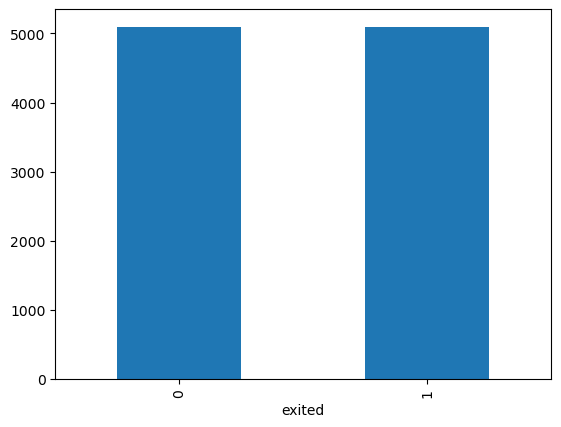

In [42]:
target_train_smote.value_counts().plot(kind='bar')
target_train_smote.value_counts()

The 0s and 1s in `exited` column is now balanced. We will try training our model with balanced data.

### Logistic Regression

In [43]:
# Create empty model

lr_model_smote = LogisticRegression(random_state=12345, solver='liblinear')

# Train the model
lr_model_smote.fit(features_train_smote, target_train_smote)

LogisticRegression(random_state=12345, solver='liblinear')

### Random Forest

In [44]:
# Create dictionary to store hyperparameters

param_rf_smote = {'n_estimators': np.arange(1,10),
                 'max_depth': np.arange(1,20)}

# Create random model

rf_smote = RandomForestClassifier(random_state=12345)

# Search for best hyperparameter

rf_grid_smote = GridSearchCV(rf_smote, param_grid = param_rf_smote)

# Fit data to best hyperparameter and assign best one to a variable

rf_grid_smote.fit(features_train_smote, target_train_smote)

best_rf_smote = rf_grid_smote.best_estimator_

print(f' Best hyperparameter for random forest using SMOTE is {best_rf_smote}')

 Best hyperparameter for random forest using SMOTE is RandomForestClassifier(max_depth=19, n_estimators=9, random_state=12345)


### Decision Tree

In [45]:
# Create dictionary to store hyperparamers

param_dt_smote = {'max_depth':np.arange(1,20)}

# Create random model

dt_smote = DecisionTreeClassifier(random_state=12345)

# Search for best hyperparameter

dt_grid_smote = GridSearchCV(dt_smote, param_grid = param_dt_smote)

# Fit data to best hyperparameter and assign best one to a variable

dt_grid_smote.fit(features_train_smote, target_train_smote)

best_dt_smote = rf_grid_smote.best_estimator_

print(f' Best hyperparameter for decision tree using SMOTE is {best_rf_smote}')

 Best hyperparameter for decision tree using SMOTE is RandomForestClassifier(max_depth=19, n_estimators=9, random_state=12345)


### Scores from above models with balanced data using SMOTE

In [46]:
smote_models = [lr_model_smote,best_rf_smote,best_dt_smote,]

smote_data = scores(smote_models)

smote_data

,Logistic Regression,Random Forest,Decision Tree
recall,0.71,0.61,0.61
precision,0.40,0.55,0.55
f1,0.51,0.58,0.58
roc_auc,0.79,0.81,0.81


The F1 score achieved 59 for both random forest and decision tree this time. We could stop here but want to test out if we can achieve even better score with undersampling

# Random Under Sampler

Undersampling will remove data from the majority class until it matches the number of the minority class. It will require less time to train the model as the dataset is smaller. However, it may remove useful information or lead to biased of data.

In [47]:
from imblearn.under_sampling import RandomUnderSampler

### Logistic Regression

In [48]:
# Randomly under sample the majority class

lr_model_rus = RandomUnderSampler(random_state=12345)

features_train_rus, target_train_rus = lr_model_rus.fit_resample(features_train, target_train)

In [49]:
# Create an empty model

lr_model_rus = LogisticRegression(random_state=12345, solver='liblinear')

# Train the model

lr_model_rus.fit(features_train_rus, target_train_rus)

LogisticRegression(random_state=12345, solver='liblinear')

### Random Forest

In [50]:
# Create dictionary for hyperparameter

param_rf_rus = {'n_estimators': np.arange(1,10),
               'max_depth':np.arange(1,20)}

# Create random model

rf_rus = RandomForestClassifier(random_state=12345)

# Use grid search to find best hyperparameters

rf_grid_rus = GridSearchCV(rf_rus, param_grid=param_rf_rus)

# Fit the data with best hyperparameter and store in a variable

best_rf_rus = rf_grid_rus.fit(features_train_rus,target_train_rus).best_estimator_

print(f' Best hyperparameter for random forest using random under sampler is {best_rf_rus}')

 Best hyperparameter for random forest using random under sampler is RandomForestClassifier(max_depth=9, n_estimators=9, random_state=12345)


### Decision Tree

In [51]:
# Create dictionary for hyperparameter

param_dt_rus = {'max_depth':np.arange(1,20)}

# Create a random model

dt_rus = DecisionTreeClassifier(random_state=12345)

# Use grid search to find best hyperparameter

dt_grid_rus = GridSearchCV(dt_rus,param_grid = param_dt_rus)

# Fit the data with best hyperparameter and store in a variable

best_dt_rus = dt_grid_rus.fit(features_train_rus,target_train_rus)

print(f' Best hyperparameter for decision tree using random under sampler is {best_rf_rus}')

 Best hyperparameter for decision tree using random under sampler is RandomForestClassifier(max_depth=9, n_estimators=9, random_state=12345)


### Scores from above models with balanced data using random under sampler

In [52]:
rus_models = [lr_model_rus, best_rf_rus, best_rf_rus]

rus_data = scores(rus_models)

rus_data

,Logistic Regression,Random Forest,Decision Tree
recall,0.71,0.75,0.75
precision,0.40,0.50,0.50
f1,0.51,0.60,0.60
roc_auc,0.79,0.85,0.85


The F1 score and roc_auc score both have improved for random forest and decision tree. The f1 score for logistic regression has also improved significantly.

# Testing Dataset

## Using Random Forest from random under sampler on testing data

After testing balancing the dataset with different methods, random under sampler returns the best F1 score of 0.6 for both random forest and decision tree classifier.

Therefore, I will use model that was trained with random under sampler on our testing data. The f1 and roc_auc have the same score for both decision tree and random forest. I will pick random forest as it prevents overfitting.

In [53]:
# Create data frame to store the scores

test_scores = pd.DataFrame(columns=['Random Forest'])

# Predicting testing set features

predictions_test_rus = best_dt_rus.predict(features_test)

# Getting the scores
precision_rus = round(precision_score(target_test,predictions_test_rus),2)
recall_rus = round(recall_score(target_test, predictions_test_rus),2)
f1_rus = round(f1_score(target_test,predictions_test_rus),2)
probabilities_test = best_dt_rus.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]
roc_auc_rus = round(roc_auc_score(target_test,probabilities_one_test),2)

test_scores.loc['precision'] = precision_rus
test_scores.loc['recall'] = recall_rus
test_scores.loc['f1']=f1_rus
test_scores.loc['roc_auc']= roc_auc_rus

test_scores

,Random Forest
precision,0.57
recall,0.67
f1,0.61
roc_auc,0.83


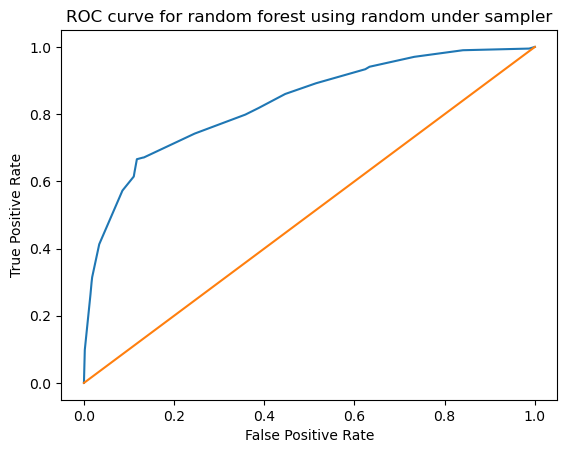

In [54]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.title('ROC curve for random forest using random under sampler')
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Conclusion

The goal of the project is to predict whethere a customer will churn. We have clients past behavior to build our model. The goal is to have F1 score of at least 0.59.

We first examine the data and noticed there are missing rows for `tenure` column. We filled the `tenure` column with median value.

After filling in missing values, I prepare the data by dropping `rownumber`, `customerid` and `surname` as they are not relevant to predicting customer churn. There are 2 categorical columns `geography` and `gender` so I used one hot encoding to transform the data. In addition, to one hot encoding, I have used the standard scaler to scale columns to make sure all the values are balanced out before training the model. Lastly, I split the model into training, validation and test set.

There is imbalance data class for our target column exited . I tested logistic regression, random forest and decision tree on imbalance class as a baseline. However, the F1 score was not desirable. Subsequently, I used random over sampler, class weight adjustment, SMOTE and random under sampler to balance the class and trained the 3 models.

Random under sampler returns the best F1 score and roc_auc for random forest and decision tree. I chose random forest because it is better at avoid overfitting problem.

The F1 score for the testing set is 0.61. The model is able to correctly identify 83% of the true positives and 17% of the false positives.